In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/208.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/473.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/333.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/45.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/369.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/56.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/89.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/20.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/275.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/212.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/239.jpg
/kaggle/input/cityscapes-image-pairs/cityscapes_data/cityscapes_data/val/58.jpg
/kaggle/input/cityscapes-image-pa

In [1]:
import os
path='/kaggle/input/cityscapes-image-pairs'
os.listdir(path)

['cityscapes_data']

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm

In [3]:
labels = [
    ['road', 'flat', [128, 64, 128]],
    ['sidewalk', 'flat', [244, 35, 232]],
    ['building', 'construction', [70, 70, 70]],
    ['wall', 'construction', [102, 102, 156]],
    ['fence', 'construction', [190, 153, 153]],
    ['pole', 'object', [153, 153, 153]],
    ['traffic light', 'object', [250, 170, 30]],
    ['traffic sign', 'object', [220, 220, 0]],
    ['vegetation', 'nature', [107, 142, 35]],
    ['terrain', 'nature', [152, 251, 152]],
    ['sky', 'sky', [70, 130, 180]],
    ['person', 'human', [220, 20, 60]],
    ['rider', 'human', [255, 0, 0]],
    ['car', 'vehicle', [0, 0, 142]],
    ['truck', 'vehicle', [0, 0, 70]],
    ['bus', 'vehicle', [0, 60, 100]],
    ['train', 'vehicle', [0, 80, 100]],
    ['motorcycle', 'vehicle', [0, 0, 230]],
    ['bicycle', 'vehicle', [119, 11, 32]],
]


# Assign trainIds starting from 0
id2color = {i: np.array(label[2]) for i, label in enumerate(labels)}
color2trainId = {tuple(label[2]): i for i, label in enumerate(labels)}


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [5]:
data_dir = os.path.join("/kaggle","input","cityscapes-image-pairs","cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


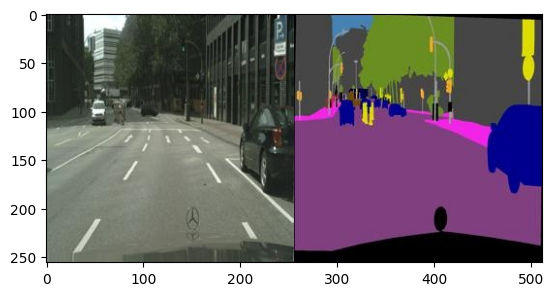

In [6]:
sample_image_show = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_show).convert("RGB")
plt.imshow(sample_image)
print(sample_image_show)

In [7]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

In [8]:
def find_closest_labels_vectorized(mask, color2trainId):
    closest_distance = np.full((mask.shape[0], mask.shape[1]), 1e6)
    closest_category = np.full((mask.shape[0], mask.shape[1]), 255)

    for color, trainId in color2trainId.items():
        color = np.array(color)
        dist = np.linalg.norm(mask - color.reshape((1, 1, 3)), axis=-1)
        is_closer = dist < closest_distance
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, trainId, closest_category)

    return closest_category

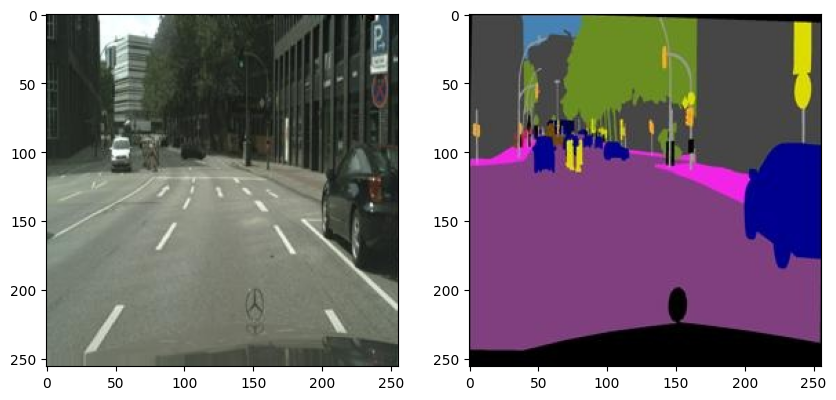

In [9]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [10]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 
    mask = np.array(mask)
    
    return image, mask


In [11]:
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

In [12]:
train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
#val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
train_images = [] 
train_masks = []
train_masks_enc = []
#val_images = []
#val_masks = []
#val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))
    
# for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
#     image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
#     val_images.append(image)
#     val_masks.append(mask)
#     val_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))

Building Training Dataset:   0%|          | 0/2975 [00:00<?, ?it/s]

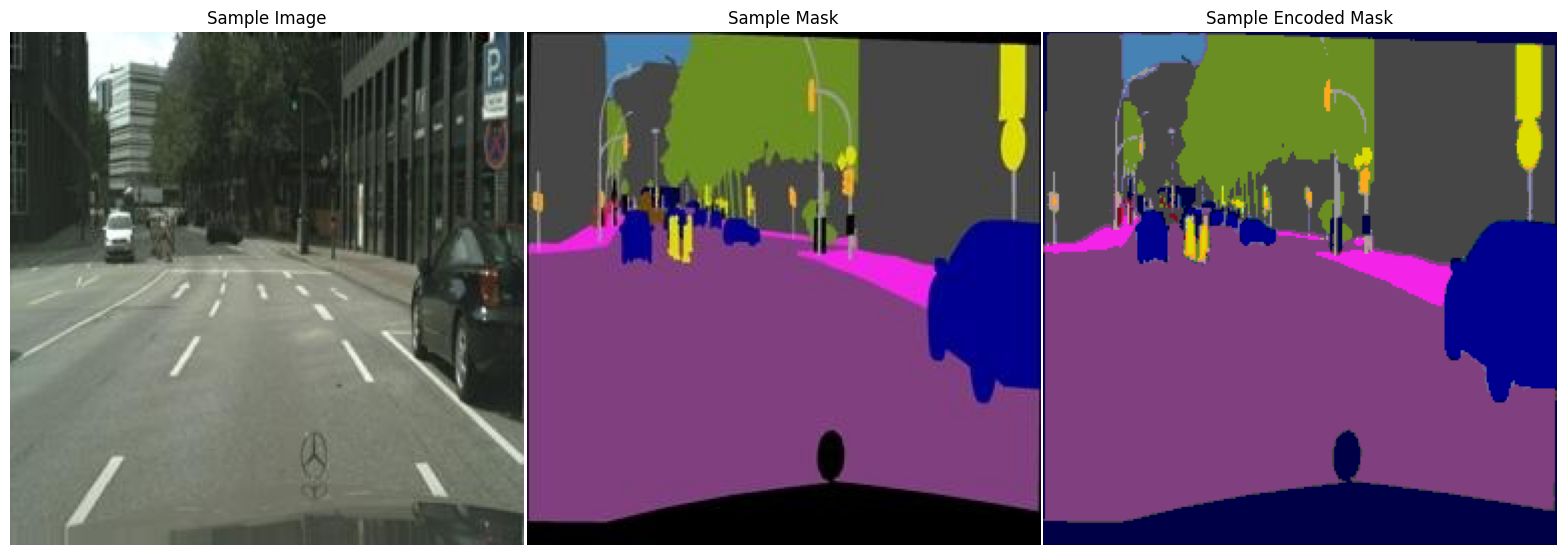

In [13]:
plt.figure(figsize=[20, 14])

for i in range(1):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]  # Should be shape [H, W], with trainIds (0–18)

    tmp = np.zeros([enc.shape[0], enc.shape[1], 3], dtype=np.uint8)

    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[int(enc[row, col])]

    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Image')

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.title('Sample Mask')

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.title('Sample Encoded Mask')

plt.subplots_adjust(wspace=0, hspace=0.1)


In [14]:
del train_masks# val_masks

In [15]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')


In [16]:
unique_vals = np.unique(train_masks_enc)
print("Unique mask labels:", unique_vals)

Unique mask labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.se = SEBlock(out_channels) 

    def forward(self, x):
        x = self.conv(x)
        return self.se(x)

class Segmentation(nn.Module):
    def __init__(self, in_channels=3, out_channels=19, features=[64, 128, 256, 512]):
        super(Segmentation, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [18]:
class CustomTrainDataset(Dataset):
    def __init__(self, images, masks_enc, transform=None):
        self.images = images
        self.masks_enc = masks_enc
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")
        print(f"total valid mask:{len(self.masks_enc)}")

    def __len__(self):
        return len(self.images)
        

    def __getitem__(self, idx):
        image = self.images[idx]
        mask_enc = self.masks_enc[idx]

       
        image = torch.tensor(image).permute(2, 0, 1).float()  
        mask_enc = torch.tensor(mask_enc).long()  

        if self.transform:
            image = self.transform(image)
            mask_enc = self.transform(mask_enc)

        return image, mask_enc



In [19]:
from torch.utils.data import DataLoader
train_dataset = CustomTrainDataset(train_images, train_masks_enc)
#val_dataset = CustomTrainDataset(val_images, val_masks_enc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
for image,mask_enc in train_loader:
  print("Train batch-Clean images shape:",image.shape)
  print("Train batch-Mask shape:",mask_enc.shape)
  break
# for image, mask_enc in val_loader:
#   print("Val batch - Clean images shape:", image.shape)
#   print("Val batch - Mask shape:", mask_enc.shape)
#   break


Total valid images: 2975
total valid mask:2975
Train batch-Clean images shape: torch.Size([8, 3, 256, 256])
Train batch-Mask shape: torch.Size([8, 256, 256])


In [20]:
def sanitize_mask_labels(mask):
    # Torch tensors don't have .copy(), and we want to avoid modifying in-place
    mask = mask.clone()  # use .clone() for torch tensors
    mask[mask > 19] = 255
    return mask

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Correct import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Segmentation(in_channels=3, out_channels=19).to(device)

lossc = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for clean, mask in train_loader_tqdm:
        clean = clean.to(device)
        mask=sanitize_mask_labels(mask).to(device)

        optimizer.zero_grad()
        output = model(clean)
        loss = lossc(output, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # # Validation
    # model.eval()
    # val_loss = 0.0
    # val_loader_tqdm = tqdm(val_loader, desc="Validating", leave=False)

    # with torch.no_grad():
    #     for clean, mask in val_loader_tqdm:
    #         clean = clean.to(device)
    #         mask=sanitize_mask_labels(mask).to(device)
    #         output = model(clean)
    #         loss = lossc(output, mask)
    #         val_loss += loss.item()
    #         val_loader_tqdm.set_postfix(val_loss=loss.item())

    # avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f} ")



Epoch [1/50]


Epoch [1/50] ➤ Train Loss: 2.0084 

Epoch [2/50]


Epoch [2/50] ➤ Train Loss: 1.2569 

Epoch [3/50]


Epoch [3/50] ➤ Train Loss: 0.9467 

Epoch [4/50]


Epoch [4/50] ➤ Train Loss: 0.8144 

Epoch [5/50]


Epoch [5/50] ➤ Train Loss: 0.7458 

Epoch [6/50]


Epoch [6/50] ➤ Train Loss: 0.7003 

Epoch [7/50]


Epoch [7/50] ➤ Train Loss: 0.6678 

Epoch [8/50]


Epoch [8/50] ➤ Train Loss: 0.6443 

Epoch [9/50]


Epoch [9/50] ➤ Train Loss: 0.6211 

Epoch [10/50]


Epoch [10/50] ➤ Train Loss: 0.6067 

Epoch [11/50]


Epoch [11/50] ➤ Train Loss: 0.5913 

Epoch [12/50]


Epoch [12/50] ➤ Train Loss: 0.5757 

Epoch [13/50]


Epoch [13/50] ➤ Train Loss: 0.5692 

Epoch [14/50]


Epoch [14/50] ➤ Train Loss: 0.5547 

Epoch [15/50]


Epoch [15/50] ➤ Train Loss: 0.5440 

Epoch [16/50]


Epoch [16/50] ➤ Train Loss: 0.5333 

Epoch [17/50]


Epoch [17/50] ➤ Train Loss: 0.5208 

Epoch [18/50]


Epoch [18/50] ➤ Train Loss: 0.5131 

Epoch [19/50]


Epoch [19/50] ➤ Train Loss: 0.5029 

Epoch [20/50]


Epoch [20/50] ➤ Train Loss: 0.4995 

Epoch [21/50]


Epoch [21/50] ➤ Train Loss: 0.4883 

Epoch [22/50]


Epoch [22/50] ➤ Train Loss: 0.4797 

Epoch [23/50]


Epoch [23/50] ➤ Train Loss: 0.4734 

Epoch [24/50]


Epoch [24/50] ➤ Train Loss: 0.4690 

Epoch [25/50]


Epoch [25/50] ➤ Train Loss: 0.4603 

Epoch [26/50]


Epoch [26/50] ➤ Train Loss: 0.4534 

Epoch [27/50]


Epoch [27/50] ➤ Train Loss: 0.4498 

Epoch [28/50]


Epoch [28/50] ➤ Train Loss: 0.4443 

Epoch [29/50]


Epoch [29/50] ➤ Train Loss: 0.4362 

Epoch [30/50]


Epoch [30/50] ➤ Train Loss: 0.4275 

Epoch [31/50]


Training:  70%|██████▉   | 259/372 [02:16<00:59,  1.90it/s, loss=0.633]

In [ ]:
test_filepath='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
test_images = []
test_masks=[]# Assuming test images are in a folder
for file in tqdm(os.listdir(test_filepath), desc="Loading Test Images"):
    image,label = image_mask_split(test_filepath + file, IMAGE_SIZE)  # Define this
    test_images.append(image)
    test_masks.append(label)


In [27]:
test_images = np.stack(test_images).astype('float32')
test_masks=np.stack(test_masks).astype('float32')

In [28]:
class CustomTestDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")
        print(f"total valid mask:{len(self.masks)}")

    def __len__(self):
        return len(self.images)
        

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

      
        image = torch.tensor(image).permute(2, 0, 1).float()  
        mask = torch.tensor(mask).long() 

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



In [29]:
test_dataset = CustomTrainDataset(test_images, test_masks)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Total valid images: 500
total valid mask:500


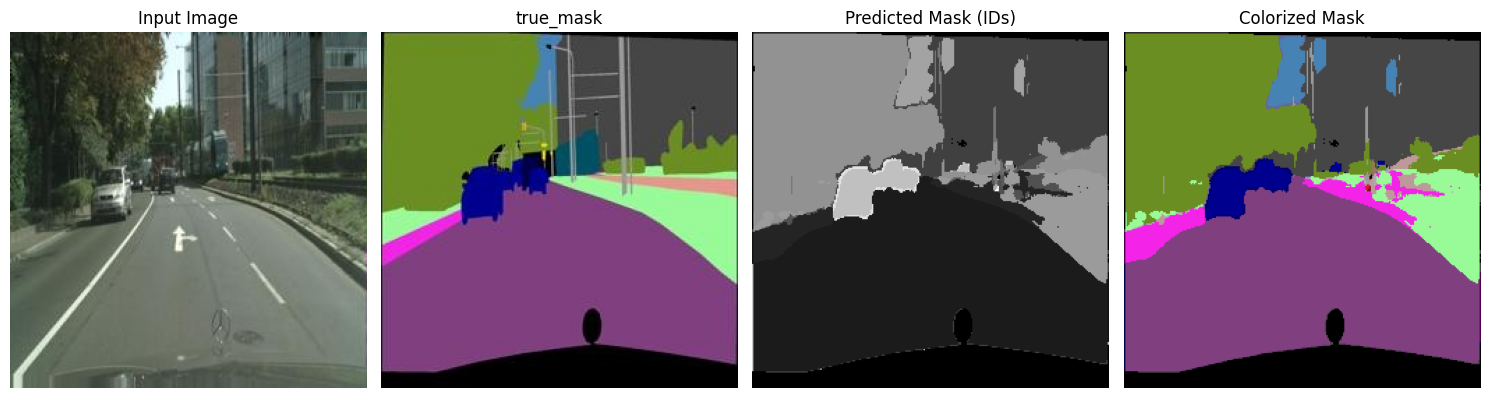

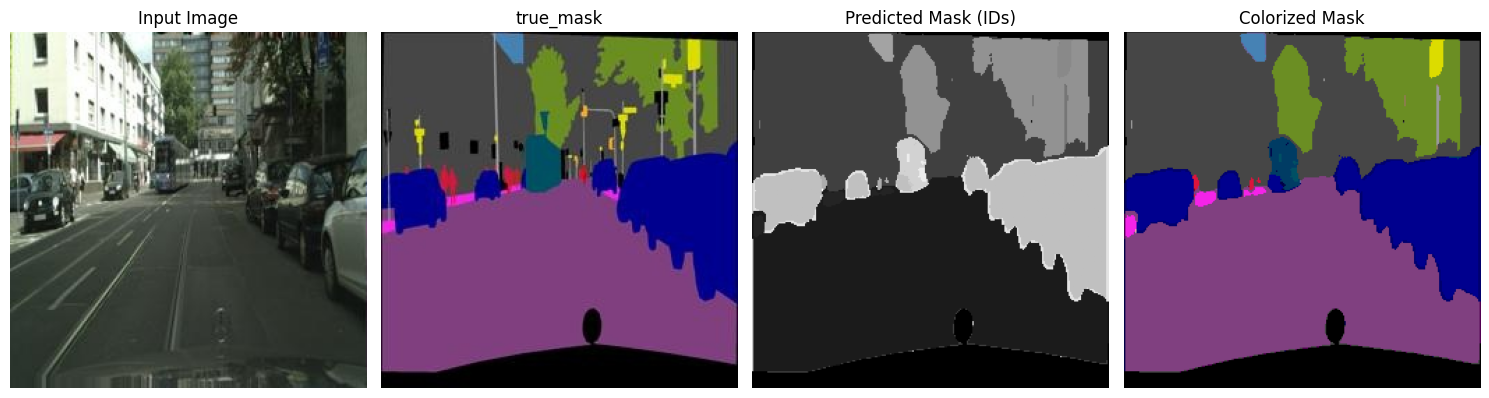

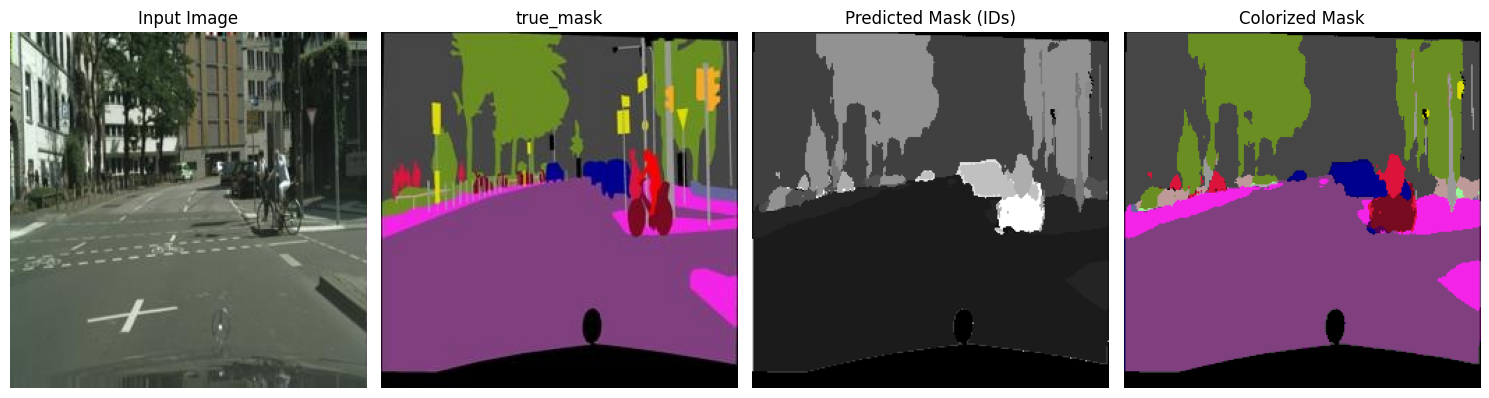

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def decode_pred_mask(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for id, color in id2color.items():
        color_mask[mask_np == id] = color
    return color_mask


model.eval()
with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  

        for i in range(min(3, len(images))): 
            input_img = images[i].cpu().permute(1, 2, 0).numpy()
            pred_mask = preds[i]
            true_mask=names[i].cpu()
            color_mask = decode_pred_mask(pred_mask)

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 4, 1)
            plt.imshow(input_img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1,4,2)
            plt.imshow(true_mask)
            plt.title("true_mask")
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.imshow(pred_mask.cpu(), cmap='gray')
            plt.title("Predicted Mask (IDs)")
            plt.axis("off")

            plt.subplot(1, 4, 4)
            plt.imshow(color_mask)
            plt.title("Colorized Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        break  
